In [8]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


# New function to extract trend
def extract_trend(series, window=126):  # 126 trading days is approximately 6 months
    recent_data = series.iloc[-window:]
    X = np.arange(len(recent_data)).reshape(-1, 1)
    y = recent_data.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0][0], model.intercept_[0]  # Return slope and intercept

# Modified to return trend information
def detrend_series(series):
    trend_slope, trend_intercept = extract_trend(series)
    if adfuller(series)[1] > 0.05:
        detrended = series.diff().dropna()
    else:
        detrended = series
    return detrended, (trend_slope, trend_intercept)

# Modified to return trend information
def calculate_returns_and_volatilities(prices, vol_window=20):
    returns = prices.pct_change().dropna()
    detrended_returns = {}
    trends = {}
    for column in returns.columns:
        detrended_returns[column], trends[column] = detrend_series(returns[column])
    detrended_returns = pd.DataFrame(detrended_returns)
    volatilities = detrended_returns.rolling(window=vol_window).std() * np.sqrt(252)
    return detrended_returns, volatilities, trends

# New function to add trend back to simulations
def add_trend_to_simulations(simulated_data, trends, block_size):
    trended_data = np.zeros_like(simulated_data)
    for i, asset in enumerate(trends):
        slope, intercept = trends[asset]
        # Create a 2D trend array that matches the shape of simulated_data for each asset
        trend = (np.arange(block_size) * slope + intercept).reshape(1, -1)
        trend = np.repeat(trend, simulated_data.shape[0], axis=0)
        trended_data[:, :, i] = simulated_data[:, :, i] + trend
    return trended_data

# The rest of the functions remain unchanged
def get_historical_data(tickers, start_date, end_date):
    # Simulate data (replace with actual data fetching in practice)
    np.random.seed(42)
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    data = {}
    for ticker in tickers:
        prices = 100 * np.exp(np.cumsum(np.random.normal(0.0005, 0.02, len(dates))))
        data[ticker] = pd.Series(prices, index=dates)
    return pd.DataFrame(data)

def exponential_weights(n_blocks, half_life):
    decay = np.exp(np.log(0.5) / half_life)
    weights = np.power(decay, np.arange(n_blocks, 0, -1) - 1)
    return weights / np.sum(weights)

def block_bootstrap_correlated(data, block_size, num_samples, half_life=None):
    n_obs, n_assets = data.shape
    n_blocks = n_obs - block_size + 1

    if half_life is None:
        weights = None
    else:
        weights = exponential_weights(n_blocks, half_life)

    samples = np.zeros((num_samples, block_size, n_assets))

    for i in range(num_samples):
        start_idx = np.random.choice(n_blocks, p=weights)
        samples[i] = data.iloc[start_idx:start_idx+block_size].values

    return samples

def generate_correlated_noise(corr_matrix, size):
    L = np.linalg.cholesky(corr_matrix)
    return np.dot(L, np.random.randn(corr_matrix.shape[0], size))

def randomize_volatilities_correlated(historical_volatilities, block_size, num_samples, half_life, epsilon=0.01):
    bootstrapped = block_bootstrap_correlated(historical_volatilities, block_size, num_samples, half_life)

    # Calculate correlation of volatilities across assets
    vol_corr = historical_volatilities.corr().values

    randomized_vols = np.zeros_like(bootstrapped)
    for i in range(num_samples):
        noise = generate_correlated_noise(vol_corr, bootstrapped.shape[1])
        randomized_vols[i] = bootstrapped[i] * (1 + epsilon * noise.T)

    return np.abs(randomized_vols)  # Ensure non-negative volatilities

def nearest_pd(A):
    """Find the nearest positive-definite matrix to input A."""
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_pd(A3):
        return A3
    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not is_pd(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

def is_pd(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

def correlation_matrix_to_vector(matrix):
    """Convert a correlation matrix to a vector of its upper triangular elements."""
    return matrix[np.triu_indices(matrix.shape[0], k=1)]

def vector_to_correlation_matrix(vector, n):
    """Convert a vector of correlation values to a correlation matrix."""
    matrix = np.eye(n)
    matrix[np.triu_indices(n, k=1)] = vector
    matrix = matrix + matrix.T - np.eye(n)
    return matrix

def randomize_correlations_correlated(historical_returns, block_size, num_samples, half_life, epsilon=0.01):
    n_assets = historical_returns.shape[1]

    # Calculate historical correlations
    historical_corrs = historical_returns.rolling(window=block_size).corr().groupby(level=0).apply(lambda x: correlation_matrix_to_vector(x.values))
    historical_corrs = pd.DataFrame(historical_corrs.tolist(), index=historical_corrs.index)

    # Bootstrap historical correlations
    bootstrapped_corrs = block_bootstrap_correlated(historical_corrs, block_size, num_samples, half_life)

    # Calculate correlation of correlations
    corr_of_corrs = historical_corrs.corr().values

    randomized_corrs = np.zeros((num_samples, block_size, n_assets * (n_assets - 1) // 2))
    for i in range(num_samples):
        noise = generate_correlated_noise(corr_of_corrs, bootstrapped_corrs.shape[1])
        flat_corrs = bootstrapped_corrs[i] + epsilon * noise.T

        # Ensure correlation values are within [-1, 1]
        flat_corrs = np.clip(flat_corrs, -1, 1)

        # Reshape to correlation matrices and ensure they are valid
        for j in range(block_size):
            corr_matrix = vector_to_correlation_matrix(flat_corrs[j], n_assets)
            corr_matrix = nearest_pd(corr_matrix)  # Ensure positive definiteness
            randomized_corrs[i, j] = correlation_matrix_to_vector(corr_matrix)

    return randomized_corrs

def estimate_ou_parameters(returns, dt=1/252):
    """
    Estimate Ornstein-Uhlenbeck parameters from historical correlation data.

    returns: DataFrame of historical returns
    dt: time step (default is daily)
    """
    try:
        # Calculate historical correlations
        correlations = returns.rolling(window=126).corr()  # 6-month rolling window

        # Extract upper triangular correlations and calculate their mean
        mean_correlations = correlations.groupby(level=0).apply(
            lambda x: np.mean(x.values[np.triu_indices(x.shape[0], k=1)])
        )

        # Calculate differences and lagged values
        diff = mean_correlations.diff().dropna()
        lagged = mean_correlations.shift().dropna()

        # Ensure diff and lagged have the same length
        min_length = min(len(diff), len(lagged))
        diff = diff[-min_length:]
        lagged = lagged[-min_length:]

        # Perform linear regression
        X = sm.add_constant(lagged)
        model = sm.OLS(diff, X).fit()

        # Extract parameters
        if len(model.params) < 2:
            raise ValueError("Regression model did not produce expected parameters")

        theta = -np.log(model.params[1]) / dt
        mu = model.params[0] / (model.params[1] - 1)
        sigma = np.sqrt(model.mse / (2 * theta * (1 - np.exp(-2 * theta * dt))))

        return theta, mu, sigma

    except Exception as e:
        print(f"Error in estimating OU parameters: {str(e)}")
        print("Calculating fallback values based on historical data")

        # Fallback calculations
        historical_corr = returns.corr()
        fallback_mu = np.mean(historical_corr.values[np.triu_indices(historical_corr.shape[0], k=1)])
        fallback_sigma = np.std(mean_correlations.diff().dropna())
        fallback_theta = 2.0  # This is harder to estimate, so we'll use a fixed value

        print(f"Fallback values - theta: {fallback_theta:.4f}, mu: {fallback_mu:.4f}, sigma: {fallback_sigma:.4f}")
        return fallback_theta, fallback_mu, fallback_sigma

def calculate_long_term_average_correlation(historical_returns):
    corr_matrix = historical_returns.corr().values
    return (corr_matrix.sum() - corr_matrix.shape[0]) / (corr_matrix.shape[0] * (corr_matrix.shape[0] - 1))

def ornstein_uhlenbeck_process(initial_value, mean, theta, sigma, dt, num_steps):
    """
    Simulate an Ornstein-Uhlenbeck process.

    initial_value: starting value
    mean: long-term mean
    theta: rate of mean reversion
    sigma: volatility
    dt: time step
    num_steps: number of steps to simulate
    """
    x = np.zeros(num_steps)
    x[0] = initial_value
    for i in range(1, num_steps):
        dx = theta * (mean - x[i-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        x[i] = x[i-1] + dx
    return x

# Modified to incorporate trend, ensuring shape consistency
def predict_average_correlation(historical_returns, historical_volatilities, trends, num_simulations, prediction_days, half_life, theta, mu, sigma, block_size):
    # Randomize volatilities while preserving cross-asset correlations
    random_vols = randomize_volatilities_correlated(historical_volatilities, block_size, num_simulations, half_life)

    # Add trend back to volatilities, ensuring shape consistency
    trended_vols = add_trend_to_simulations(random_vols, trends, block_size)

    # Randomize correlations while preserving correlation of correlations
    random_corrs = randomize_correlations_correlated(historical_returns, block_size, num_simulations, half_life)

    avg_correlations = []

    dt = 1 / 252  # Daily time step

    for i in range(num_simulations):
        # Use the last correlation from the randomized correlations as the initial value
        initial_corr = np.mean(vector_to_correlation_matrix(random_corrs[i, -1], historical_returns.shape[1])[np.triu_indices(historical_returns.shape[1], k=1)])

        # Generate mean-reverting correlation path using calibrated parameters
        corr_path = ornstein_uhlenbeck_process(initial_corr, mu, theta, sigma, dt, prediction_days)

        sim_corrs = []
        for j in range(prediction_days):
            corr_matrix = np.full((historical_returns.shape[1], historical_returns.shape[1]), corr_path[j])
            np.fill_diagonal(corr_matrix, 1)

            # Ensure the correlation matrix is positive definite
            corr_matrix = nearest_pd(corr_matrix)

            L = np.linalg.cholesky(corr_matrix)
            uncorrelated_returns = np.random.standard_normal(historical_returns.shape[1])
            correlated_returns = L @ uncorrelated_returns

            # Use trended volatilities for the current day
            day_index = j % block_size  # This ensures we cycle through the block if prediction_days > block_size
            scaled_returns = correlated_returns * trended_vols[i, day_index, :]

            sim_corr_matrix = np.outer(scaled_returns, scaled_returns)
            sim_corrs.append(sim_corr_matrix)

        avg_corr = np.mean([np.mean(c[np.triu_indices(c.shape[0], k=1)]) for c in sim_corrs])
        avg_correlations.append(avg_corr)

    return avg_correlations

# Main execution
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'FB', 'TSLA', 'BRK.B', 'NVDA', 'JPM', 'JNJ']
start_date = '2010-01-01'
end_date = '2023-01-01'

historical_prices = get_historical_data(tickers, start_date, end_date)
historical_returns, historical_volatilities, trends = calculate_returns_and_volatilities(historical_prices)

# Calibrate Ornstein-Uhlenbeck parameters
theta, mu, sigma = estimate_ou_parameters(historical_returns)

print(f"Calibrated OU parameters: theta={theta:.4f}, mu={mu:.4f}, sigma={sigma:.4f}")

num_simulations = 10000
prediction_days = 126  # Approximately 6 months of trading days
half_life = 60  # Adjust as needed
block_size = 63  # You can now set this to any value you want

# Modify the predict_average_correlation function call to include block_size
avg_correlations = predict_average_correlation(historical_returns, historical_volatilities, trends, num_simulations, prediction_days, half_life, theta, mu, sigma, block_size)

predicted_avg_correlation = np.mean(avg_correlations)

print(f"Predicted average 6-month correlation: {predicted_avg_correlation:.4f}")

Error in estimating OU parameters: 1
Calculating fallback values based on historical data
Fallback values - theta: 2.0000, mu: 0.0024, sigma: 0.0017
Calibrated OU parameters: theta=2.0000, mu=0.0024, sigma=0.0017
Predicted average 6-month correlation: 0.0006


Predicted average 6-month correlation: 0.0084

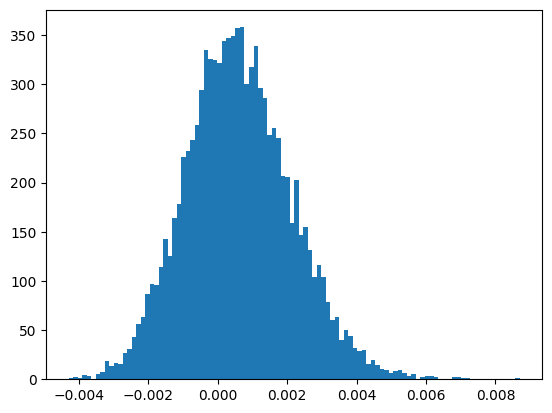

In [9]:
import matplotlib.pyplot as plt
plt.hist(avg_correlations, bins=100)
plt.show()